# Improving statistical models w/ ML visualizations

Machine learning models like XGBoost are incredibly powerful tools, but they are often too "black box" to use in production. It is unclear what value they have in such contexts. 

This notebook will demonstrate a procedure to take advantage of a sophisticated ML model without actually using it in production. The idea is to fit an ML model, look at its partial dependence plots, and use them as inspiration to improve feature engineering. This way we can discover and take advantage of complex feature-response relationships without deploying a black-box algorithm.

We will be working in the field of healthcare, where interpretability is often essential. In particular, we will be predicting morbidity in the National Inpatient Sample from 2016, a very large data set of hospital visits. While this dataset is entirely anonymized with no personal identifiers, it is still not public for privacy reasons (see footnote)

## 1. Making a model

In [88]:
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import loguniform, uniform
import xgboost
import pandas as pd
from hcuppy.elixhauser import ElixhauserEngine
import re
from sklearn.model_selection import train_test_split

Reading the data

In [ ]:
df = pd.read_csv('../NIS2016.csv')

One of the most important properties of each patient in the NIS is their list of preexisting diagnoses. Each patient could have zero, one, or many diagnoses, so the diagnosis data is tricky to use as a feature

We will summarize each patients' diagnosis list with the Elixhauser score, a weighting of various diagnoses designed to predict future morbidity. Fortunately, the python package hcuppy provides a function to calculate it for us. 

In [ ]:
ee = ElixhauserEngine()

diagnosis_cols = [z for z in df.columns if 'I10_DX' in z]
df[diagnosis_cols] = df[diagnosis_cols].fillna('NO_DX') #N/As will break regex expressions
all_columns = diagnosis_cols + ['AGE','DIED','APRDRG_Severity','DRG','FEMALE','RACE','ZIPINC_QRTL']
df = df[all_columns]

df.loc[:,'CMB_INDEX'] = [ee.get_elixhauser(list(row[diagnosis_cols].values))['mrtlt_scr'] for index, row in df.iterrows()]
df = df.drop(columns = diagnosis_cols)

In [9]:
df['RACE'] = df['RACE'].fillna(7)
categoricals = ['RACE','APRDRG_Severity','DRG','ZIPINC_QRTL']
df[categoricals] = df[categoricals].astype('category')

In [159]:
df.shape

(7072872, 9)

Now that we done a first-pass at data engineering, we are ready to fit a machine learning model. 

We will withhold a test set, so that we can evaluate accuracy without bias later. Our dataset has more than 7 million rows, with only 9 features, so we can safely withhold only a small slice of the data for the test set. 

Our ML model will be a cross-validated XGBoost machine. Since the dataset is so large, training this will be computationally expensive. We will use a randomized search with mostly loguniform parameter distributions, to sample as broad of a selection of possible parameters as we can with our limited computational power. 

In [ ]:
training_set = df.dropna()[['AGE','DIED','FEMALE','RACE','ZIPINC_QRTL','CMB_INDEX']]
training_set = pd.get_dummies(training_set, drop_first = True)
X = training_set.drop(columns = 'DIED')
y = training_set['DIED']

X_train, X_holdout, y_train,y_holdout = train_test_split(X,y, test_size = 0.05)

xgb = xgboost.XGBClassifier()

param_dist = {'min_child_weight': loguniform(1e-4, 1e2)
              ,'gamma': loguniform(1e-4, 1e1)
              ,'sumbsample': loguniform(1e-4, 1e0)
              ,'colsample_bytree': uniform(0,1)
              ,'max_depth': [1,2,3, 4, 5,6,7,8,9,10]}

skf = StratifiedKFold(n_splits=4, shuffle = True, random_state = 0
                     )

n_iter_search = 10
random_search = RandomizedSearchCV(xgb, param_distributions=param_dist,
                                   cv = skf, #ZR: for next time 
                                   n_iter=n_iter_search)
final_xgb_model = random_search.fit(X_train, y_train)

## 2. Feature importance

Now that we have a model, we can take a look at what it is doing under the hood. To start, we will look at feature importance. Our metric of choice will be gain, because it is not biased against categorical variables in the same way that cover is

In [100]:
gain_importances = final_xgb_model.best_estimator_.get_booster().get_score(importance_type='gain')

<BarContainer object of 12 artists>

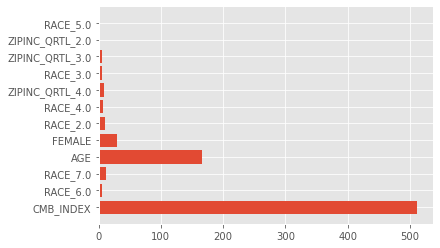

In [101]:
plt.style.use('ggplot')

plt.barh([k for k,v in gain_importances.items()], [v for k,v in gain_importances.items()])

Descriptions of the NIS features can be found [here](https://www.hcup-us.ahrq.gov/db/nation/nis/nisdde.jsp)

Unsurprisingly, the comorbidity index we calculated is by far the most important predictor. Age also has a significant effect. Every other feature, with the arguable exception of gender, is relatively unimportant in this context

Note that the ZIP income quartile features may not adequately proxy true income. Many zip codes have income disparities, introducing significant noise. 

We can also peruse the trees created by xgboost, to get a better sense of how the features are being used

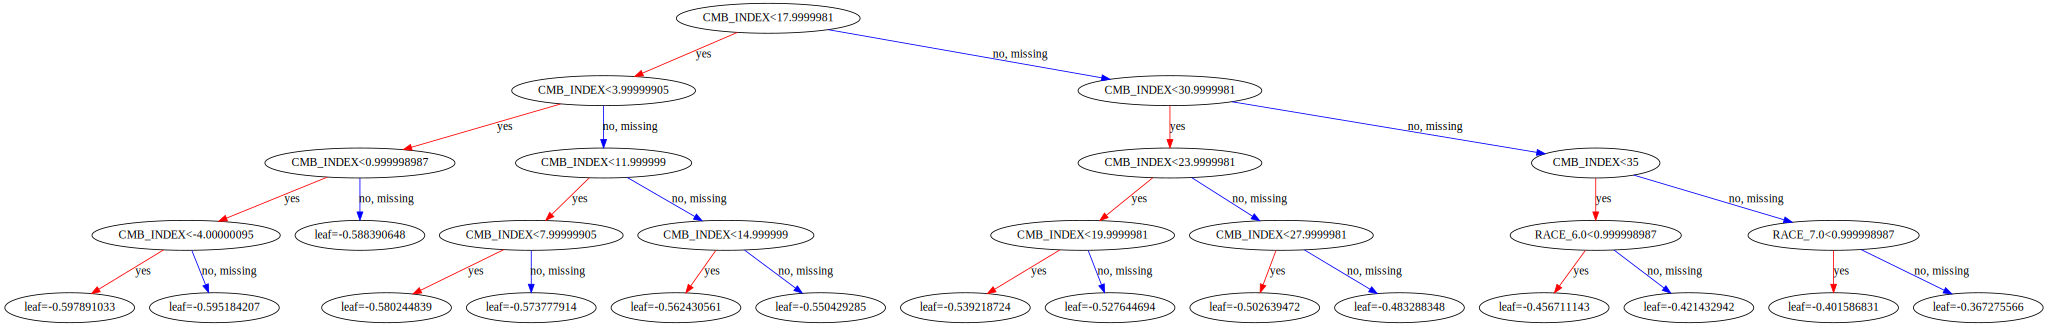

In [104]:
xgboost.to_graphviz(final_xgb_model.best_estimator_, num_trees = 0)

Note that the leaf values can be negative because they are logits. When all the tree values are added up and the logistic transformation is performed, the resulting probability will always be between 0 and 1 

## 3. Partial dependence

AGE and CMB_INDEX which seem to be the most important feature, so we will take a closer look at them. 

To see how the model is using them, we will use partial dependence plots. PDPs show the marginal contribution of a feature to the response variable across its range. This is calculated by setting the feature to a set value for every data point in the set, and observing the average response. 

Calculating PDPs across the entire dataset would take a very long time, so we will sample 100,000 data points. That should be more than enough to see the 1-dimensional trend

In [105]:
from sklearn.inspection import plot_partial_dependence

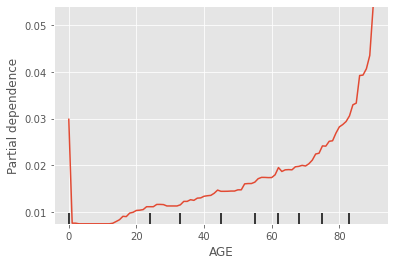

In [106]:
plot_partial_dependence(final_model, X.sample(100000), ['AGE'])

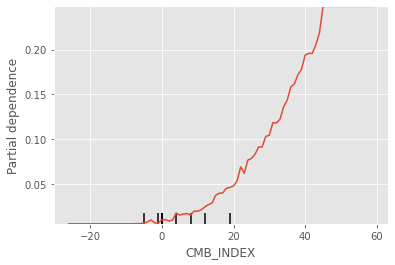

In [107]:
plot_partial_dependence(final_model, X.sample(100000), ['CMB_INDEX']) 

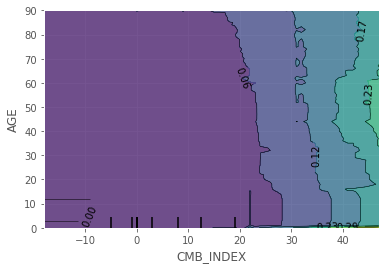

In [108]:
plot_partial_dependence(final_model, X.sample(1000), [('CMB_INDEX','AGE')])

Two observations are immediately apparent 
- Age = 0 appears to be a discontinuity,
- Both charts are mostly monotonically increasing, but in a nonlinear fashion. A logistic regression would not be able to hander this behavior by default

## 4. Using the partial dependence plots for feature engineering

Now we are going to use partial dependences to create better features, which can be fed into a logistic regression.

Why not just use a scatterplot to inspect the relationship between morbidity and the model feautres? The issue is that scatterplots are hard to interpret when features are correlated to one another. For example, older patients tend to have more comorbidities, which can confound the relationship between age and morbidity. The XGBoost model theoretically is isolating the effect of each variable in a way that works well for prediction.

We will fit splines to both partial dependence plots to generate a tractable estimation. Since AGE = 0 appears to be a discontinuity, we will remove it from the AGE spline and add it as a separate feature

In [179]:
from scipy.interpolate import UnivariateSpline
from sklearn.inspection import partial_dependence

partial_dependence_age, ages = partial_dependence(final_xgb_model
                                            , X_train[X_train['AGE'] > 0].sample(100000)
                                            , ['AGE']
                                            , kind = 'legacy') #future-proofing, since behavior will change in later sklearn 

def logit(x):
    return np.log((x/(1-x)))

#logistic regression predicts maps features to logit values, so we want partial dependence of the logits
partial_dependence_age = logit(partial_dependence_age)

age_spline = UnivariateSpline(ages, partial_dependence_age, s = 0.2)

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\sklearn\inspection\_partial_dependence.py:505: FutureWarning:

A Bunch will be returned in place of 'predictions' from version 1.1 (renaming of 0.26) with partial dependence results accessible via the 'average' key. In the meantime, pass kind='average' to get the future behaviour.



In [180]:
partial_dependence_cmb, cmbs = partial_dependence(final_xgb_model
                                            , X_train.sample(100000)
                                            , ['CMB_INDEX']) 

partial_dependence_cmb = logit(partial_dependence_cmb)
cmb_spline = UnivariateSpline(cmbs, partial_dependence_cmb, s = 0.2)


In [181]:
def replace_with_spline(df):
    new_df = df.assign(CMB_Beta = cmb_spline(df['CMB_INDEX'])
                       ,Age_Beta = age_spline(df['AGE']))
    
    new_df.loc[:,'AGE_0'] = new_df['AGE'] == 0
    
    return new_df.drop(columns = ['CMB_INDEX','AGE'])

X_train_beta = replace_with_spline(X_train)

X_holdout_beta = replace_with_spline(X_holdout)

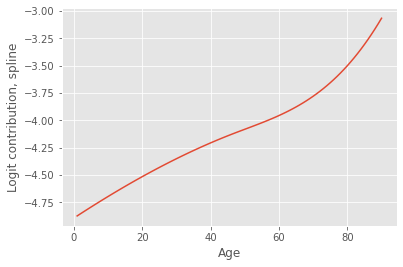

In [189]:
plt.plot(np.array(ages)[0], age_spline(ages)[0] )
plt.xlabel("Age")
plt.ylabel("Logit contribution, spline")
plt.show()

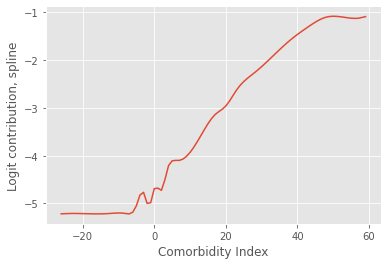

In [190]:
plt.plot(np.array(cmbs)[0], cmb_spline(cmbs)[0] )
plt.xlabel("Comorbidity Index")
plt.ylabel("Logit contribution, spline")
plt.show()

We now have a new version of the dataset, with spline-ified versions of AGE and CMB_INDEX. The last step is to see how a logistic regression will do with these features, compared to a logistic regression with original features, and XGBoost

# 5. Scoring performance

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

lr_alpha = LogisticRegression().fit(X_train,y_train)
lr_beta = LogisticRegression().fit(X_train_beta,y_train)

lr_alpha_predictions = lr_alpha.predict_proba(X_holdout)
lr_beta_predictions = lr_beta.predict_proba(X_holdout_beta)
xgb_predictions = final_xgb_model.predict_proba(X_holdout)



In [185]:
lr_alpha_score = roc_auc_score(y_holdout, [p[1] for p in lr_alpha_predictions])
lr_beta_score = roc_auc_score(y_holdout, [p[1] for p in lr_beta_predictions])
xgb_score = roc_auc_score(y_holdout, [p[1] for p in xgb_predictions])

print('Base logistic regression score: ' + str(np.round(lr_alpha_score*100,2)) + '%')
print('XGB score: ' + str(np.round(xgb_score*100,2)) + '%')
print('Augmented logistic regression score: ' + str(np.round(lr_beta_score*100,2)) + '%')

Base logistic regression score: 82.62%
XGB score: 83.47%
Augmented logistic regression score: 82.84%


The XGB model is still the best, but our new features helped the logistic regression. The gap between XGB and the logistic regression shrunk from 0.9 percentage points to 0.6 percentage points with the new features. 

In the context of healthcare, where every prediction is important, this level of improvement can meam a lot

## 6. Conclusion

ML models can be useful for understanding data even when they cannot be deployed. Thus it may be worthwhile for practitioners to try ML models in such contexts, using them for feature engineering before leaving them on the shelf for production

*This notebook is part of an ongoing collaboration w/ Safwan Jalal of Upstate Medical University. NIS data was obtained through the university*